In [1]:
import os
import librosa
from pydub import AudioSegment
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from random import sample
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import re


Bad key "text.kerning_factor" on line 4 in
/home/fstovarr/anaconda3/envs/birds/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
!ls audios/
!pwd

audios.zip  metadata.csv  mp3  wav
/home/fstovarr/birds


In [3]:
WAV_PATH = "/home/fstovarr/birds/audios/wav"
MP3_PATH = "/home/fstovarr/birds/audios/mp3"

In [16]:
wav_files = os.listdir(WAV_PATH)
mp3_files = os.listdir(MP3_PATH)

FILENAME = "data.csv"

PREPROCESSING = False

# Important only if PREPROCESSING is True
SAMPLES = len(wav_files)
THREADS = 8

In [5]:
def espectrogram(x):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb

def spectral_centroid(x, sr):
    return librosa.feature.spectral_centroid(x, sr=sr)[0]

def spectral_rolloff(x, sr):
    return librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]

def spectral_bandwidth(x, sr):
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
    return (spectral_bandwidth_2, spectral_bandwidth_3, spectral_bandwidth_4)

def zero_crossing_rate(x, sr, n0 = 9000, n1 = 9100):
    return librosa.zero_crossings(x[n0:n1], pad=False)

def mel_frequency(x, sr):
    return librosa.feature.mfcc(x, sr=sr)

def chroma(x, sr):
    return librosa.feature.chroma_stft(x, sr=sr)

In [6]:
random.shuffle(wav_files)
wav_files

['Acrocephalus-dumetorum-134919.wav',
 'Oriolus-oriolus-477401.wav',
 'Ficedula-parva-316275.wav',
 'Erithacus-rubecula-472257.wav',
 'Acrocephalus-dumetorum-297377.wav',
 'Chloris-chloris-234412.wav',
 'Aegolius-funereus-512068.wav',
 'Erithacus-rubecula-310156.wav',
 'Turdus-philomelos-168171.wav',
 'Locustella-naevia-120677.wav',
 'Crex-crex-136181.wav',
 'Fringilla-coelebs-177414.wav',
 'Emberiza-calandra-148498.wav',
 'Alauda-arvensis-476946.wav',
 'Luscinia-megarhynchos-323322.wav',
 'Acrocephalus-schoenobaenus-177170.wav',
 'Turdus-merula-325210.wav',
 'Luscinia-svecica-246461.wav',
 'Sonus-naturalis-335728.wav',
 'Parus-major-150232.wav',
 'Emberiza-cirlus-128714.wav',
 'Phylloscopus-sibilatrix-415110.wav',
 'Periparus-ater-508056.wav',
 'Troglodytes-troglodytes-243909.wav',
 'Emberiza-hortulana-200462.wav',
 'Oriolus-oriolus-477715.wav',
 'Luscinia-luscinia-135786.wav',
 'Fringilla-coelebs-141193.wav',
 'Periparus-ater-170201.wav',
 'Luscinia-megarhynchos-304600.wav',
 'Hippol

In [7]:
len(np.unique(np.array(wav_files)))

2150

In [8]:
wav_files = wav_files[0:SAMPLES]

In [9]:
import threading
from math import ceil

In [10]:
def process_data(processed_data, files):
    for file in tqdm(files):
        try:
            x, sr = librosa.load("{}/{}".format(WAV_PATH, file), sr=None)
        except Exception as e:
            print(e, "ERROR WITH FILE {}".format(file))
            continue
        
        tmp = []

        class_name = re.search('([A-za-z-]+)-[0-9]+.wav', file).group(1).lower()

        np_fft = np.fft.fft(x)
        amplitudes = 2/len(x) * np.abs(np_fft)
        tmp.append(file)
        tmp.append(class_name)

        features = [x,amplitudes,spectral_centroid(x, sr),  spectral_rolloff(x, sr),  spectral_bandwidth(x, sr),  mel_frequency(x, sr),  chroma(x, sr)]

        for f in features:
            tmp.append(np.mean(f))
            tmp.append(np.max(f))
            tmp.append(np.min(f))
            tmp.append(np.std(f))

        tmp.append(sum(zero_crossing_rate(x, sr)))
        
        csv = open(FILENAME, "a+")
        csv.write(",".join(map(str, tmp)) + "\n")
        csv.close()

In [11]:
if PREPROCESSING:
    threads = THREADS
    chunk_size = ceil(len(wav_files) / threads)
    jobs = []


    out_list = [[] for i in range(threads)]

    for i in range(0, threads):
        thread = threading.Thread(target=process_data, args=(out_list[i], wav_files[chunk_size * i : min(chunk_size * i + chunk_size, len(wav_files))]))
        jobs.append(thread)

    for j in jobs:
        j.start()

    for j in jobs:
        j.join()

In [12]:
if PREPROCESSING:
    ol = np.array(out_list)
    sz = ol.shape
    processed_data = ol.reshape((sz[0] * sz[1], sz[2]))
    print(processed_data.shape)

In [49]:
feature_names = [
    'filename',
    'class_name', 
    'wave_min', 
    'wave_max', 
    'wave_mean', 
    'wave_var', 
    'amp_min', 
    'amp_max', 
    'amp_mean', 
    'amp_var', 
    'spectral_centroid_min', 
    'spectral_centroid_max', 
    'spectral_centroid_mean', 
    'spectral_centroid_var', 
    'spectral_rolloff_min', 
    'spectral_rolloff_max', 
    'spectral_rolloff_mean', 
    'spectral_rolloff_var', 
    'spectral_bandwidth_min', 
    'spectral_bandwidth_max', 
    'spectral_bandwidth_mean', 
    'spectral_bandwidth_var', 
    'mel_frequency_min', 
    'mel_frequency_max', 
    'mel_frequency_mean', 
    'mel_frequency_var', 
    'chroma_min', 
    'chroma_max', 
    'chroma_mean', 
    'chroma_var',
    'zero_crossing_rate'
 ]

# Neuronal Network

In [14]:
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers, callbacks, Input
from keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels, filename=None, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    
    print(ymap, y_true)
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap=plt.cm.Blues)
    if filename != None:
        plt.savefig(filename)

In [57]:
data = pd.read_csv(FILENAME, names=feature_names)
data.head()

,filename,class_name,wave_min,wave_max,wave_mean,wave_var,amp_min,amp_max,amp_mean,amp_var,...,spectral_bandwidth_var,mel_frequency_min,mel_frequency_max,mel_frequency_mean,mel_frequency_var,chroma_min,chroma_max,chroma_mean,chroma_var,zero_crossing_rate
0,Hippolais-icterina-476939.wav,hippolais-icterina,-1.113427e-08,0.383163,-0.377548,0.023721,0.000013,0.000871,1.312748e-11,0.000029,...,1064.806047,-20.178236,158.12755,-688.75280,97.804085,0.415917,1.0,0.000000,0.324690,30
1,Erithacus-rubecula-507515.wav,erithacus-rubecula,-7.185017e-07,0.354980,-0.277756,0.014373,0.000007,0.000736,4.348848e-10,0.000015,...,1487.743074,-7.473933,194.46820,-697.81610,103.053085,0.564978,1.0,0.002361,0.263052,0
2,Linaria-cannabina-421682.wav,linaria-cannabina,-1.354322e-07,0.122467,-0.110748,0.007988,0.000004,0.000752,1.095046e-11,0.000008,...,765.846071,-11.453087,182.59860,-839.49370,99.838646,0.538127,1.0,0.000000,0.263558,5
3,Acrocephalus-arundinaceus-267178.wav,acrocephalus-arundinaceus,-3.773617e-06,0.109802,-0.110748,0.008166,0.000006,0.000281,3.841685e-11,0.000013,...,981.473644,-16.182085,193.25336,-786.07043,99.855896,0.481109,1.0,0.000000,0.294839,4
4,Troglodytes-troglodytes-361386.wav,troglodytes-troglodytes,6.800663e-08,0.100281,-0.099228,0.009322,0.000003,0.000139,5.058323e-12,0.000007,...,813.128931,-24.728077,154.04565,-797.11957,120.148170,0.419511,1.0,0.000000,0.325191,9


In [58]:
data.describe()

,wave_min,wave_max,wave_mean,wave_var,amp_min,amp_max,amp_mean,amp_var,spectral_centroid_min,spectral_centroid_max,...,spectral_bandwidth_var,mel_frequency_min,mel_frequency_max,mel_frequency_mean,mel_frequency_var,chroma_min,chroma_max,chroma_mean,chroma_var,zero_crossing_rate
count,2.149000e+03,2149.000000,2149.000000,2149.000000,2.149000e+03,2149.000000,2.149000e+03,2.149000e+03,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.0,2149.000000,2149.000000,2149.000000
mean,1.830183e-05,0.497655,-0.495932,0.034685,1.113358e-05,0.001669,1.537096e-10,3.166536e-05,4401.037542,8903.743132,...,1164.243239,-18.174330,150.253539,-614.884811,101.066018,0.467300,1.0,0.000861,0.308161,12.729642
std,2.907615e-03,0.298679,0.297057,0.027407,1.055213e-05,0.006128,1.091974e-09,2.989292e-05,1677.455003,2540.135551,...,339.880978,8.376168,41.251948,110.230750,17.052489,0.115016,0.0,0.007758,0.029249,11.318068
min,-7.980286e-02,0.005524,-1.000000,0.000592,1.404004e-07,0.000009,1.185175e-13,1.985936e-07,505.126886,2198.610378,...,204.812127,-43.320488,37.222942,-1116.870400,39.871666,0.030386,1.0,0.000000,0.088463,0.000000
25%,-7.889103e-06,0.242203,-0.730942,0.013978,4.127073e-06,0.000310,5.526418e-12,1.181603e-05,3309.515343,7073.671252,...,922.866439,-25.442324,125.062290,-682.739100,90.941530,0.385124,1.0,0.000000,0.295967,3.000000
50%,3.458461e-09,0.454559,-0.453888,0.028368,8.288598e-06,0.000638,1.259757e-11,2.351819e-05,4187.345866,8470.169620,...,1138.064463,-16.844128,149.875060,-605.600700,101.387924,0.453864,1.0,0.000008,0.314047,12.000000
75%,3.868654e-06,0.735641,-0.243881,0.048055,1.475062e-05,0.001325,3.555970e-11,4.215695e-05,5301.689604,10678.900625,...,1369.293316,-11.646959,173.624530,-541.503000,112.174706,0.543266,1.0,0.000065,0.325210,19.000000
max,4.562935e-02,0.999969,-0.000061,0.252685,1.368002e-04,0.159606,2.661194e-08,3.267286e-04,14572.508831,18536.294772,...,2573.315268,6.663881,320.503900,-214.406220,169.274700,0.908558,1.0,0.199908,0.398264,76.000000


In [61]:
birds_classes = data.iloc[:, 1]
class_names = birds_classes.unique()
class_names

array(['hippolais-icterina', 'erithacus-rubecula', 'linaria-cannabina',
       'acrocephalus-arundinaceus', 'troglodytes-troglodytes',
       'emberiza-hortulana', 'phoenicurus-phoenicurus',
       'emberiza-calandra', 'luscinia-svecica', 'turdus-philomelos',
       'ficedula-hypoleuca', 'cuculus-canorus', 'sylvia-atricapilla',
       'locustella-naevia', 'bubo-bubo', 'emberiza-cirlus',
       'caprimulgus-europaeus', 'carduelis-carduelis', 'strix-aluco',
       'pyrrhula-pyrrhula', 'emberiza-schoeniclus',
       'phylloscopus-sibilatrix', 'phylloscopus-collybita',
       'sylvia-borin', 'hirundo-rustica', 'fringilla-coelebs',
       'luscinia-luscinia', 'carpodacus-erythrinus',
       'glaucidium-passerinum', 'sonus-naturalis',
       'luscinia-megarhynchos', 'oriolus-oriolus', 'sylvia-communis',
       'chloris-chloris', 'acrocephalus-schoenobaenus',
       'loxia-curvirostra', 'emberiza-citrinella', 'alauda-arvensis',
       'phylloscopus-trochilus', 'athene-noctua', 'parus-major',


In [62]:
len(data.iloc[:, 1].unique())

50

In [63]:
import colorsys

N = len(class_names)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
colors = list(RGB_tuples)

In [64]:
dict_classes = {}
for i, b in enumerate(class_names):
    dict_classes[b] = i

sm_colors = [colors[dict_classes[c]] for c in birds_classes]

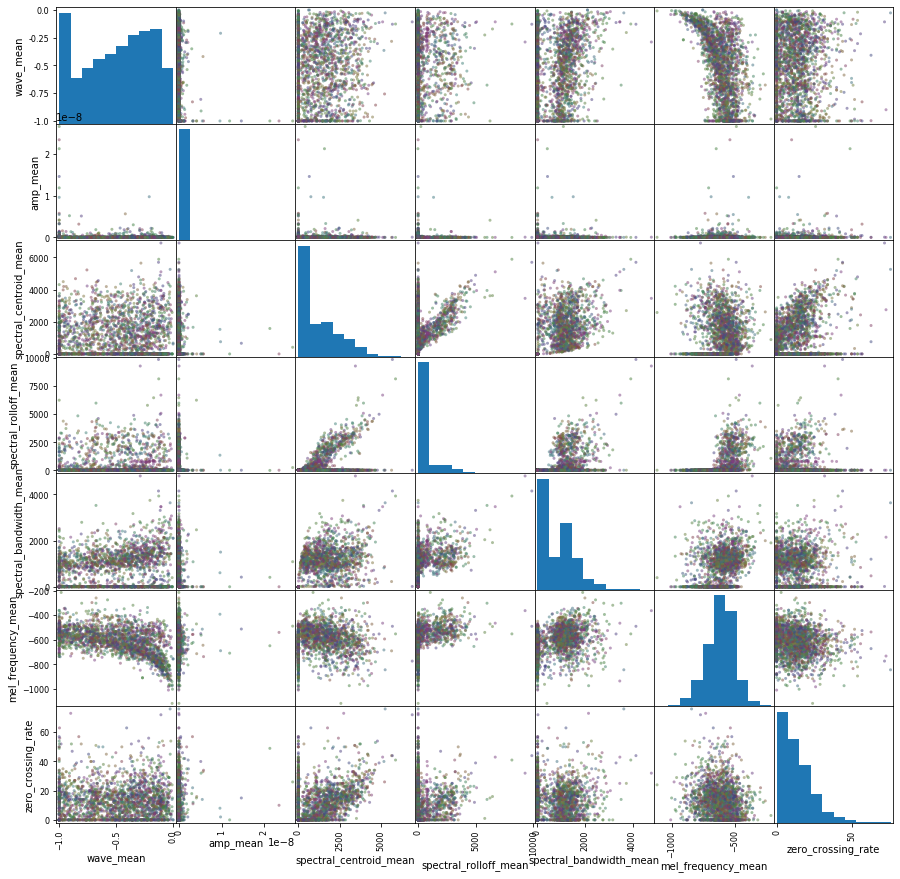

In [65]:
_ = pd.plotting.scatter_matrix(data[[
    'wave_mean', 
    'amp_mean', 
    'spectral_centroid_mean', 
    'spectral_rolloff_mean', 
    'spectral_bandwidth_mean', 
    'mel_frequency_mean', 
    'zero_crossing_rate'
]], c=sm_colors, figsize=(15, 15))

In [292]:
# sns_plot = sns.pairplot(data[[
#     'class_name',
#     'wave_mean', 
#     'amp_mean', 
#     'spectral_centroid_mean', 
#     'spectral_rolloff_mean', 
#     'spectral_bandwidth_mean', 
#     'mel_frequency_mean', 
#     'zero_crossing_rate'
# ]], hue="class_name")

In [427]:
# data = data[['wave_mean', 
#     'amp_mean', 
#     'spectral_centroid_mean', 
#     'spectral_rolloff_mean', 
#     'spectral_bandwidth_mean', 
#     'mel_frequency_mean', 
#     'zero_crossing_rate']]

In [66]:
encoder = LabelEncoder()
y = encoder.fit_transform(birds_classes)
num_classes = max(y) + 1

In [67]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, 3:]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [68]:
print(len(X_test))
print(len(X_train))

430
1719


{0: 0.84, 1: 0.8, 2: 0.8, 3: 0.76, 4: 0.84, 5: 0.84, 6: 0.78, 7: 0.78, 8: 0.82, 9: 0.84, 10: 0.78, 11: 0.78, 12: 0.76, 13: 0.82, 14: 0.86, 15: 0.8, 16: 0.9, 17: 0.7, 18: 0.84, 19: 0.78, 20: 0.84, 21: 0.9, 22: 0.78, 23: 0.74, 24: 0.9, 25: 0.66, 26: 0.76, 27: 0.84, 28: 0.74, 29: 0.7, 30: 0.82, 31: 0.86, 32: 0.7, 33: 0.84, 34: 0.78, 35: 0.78, 36: 0.8, 37: 0.84, 38: 0.76, 39: 0.8, 40: 0.88, 41: 0.8, 42: 0.74, 43: 0.72, 44: 0.8, 45: 0.9, 46: 0.76, 47: 0.76, 48: 0.76, 49: 0.92}


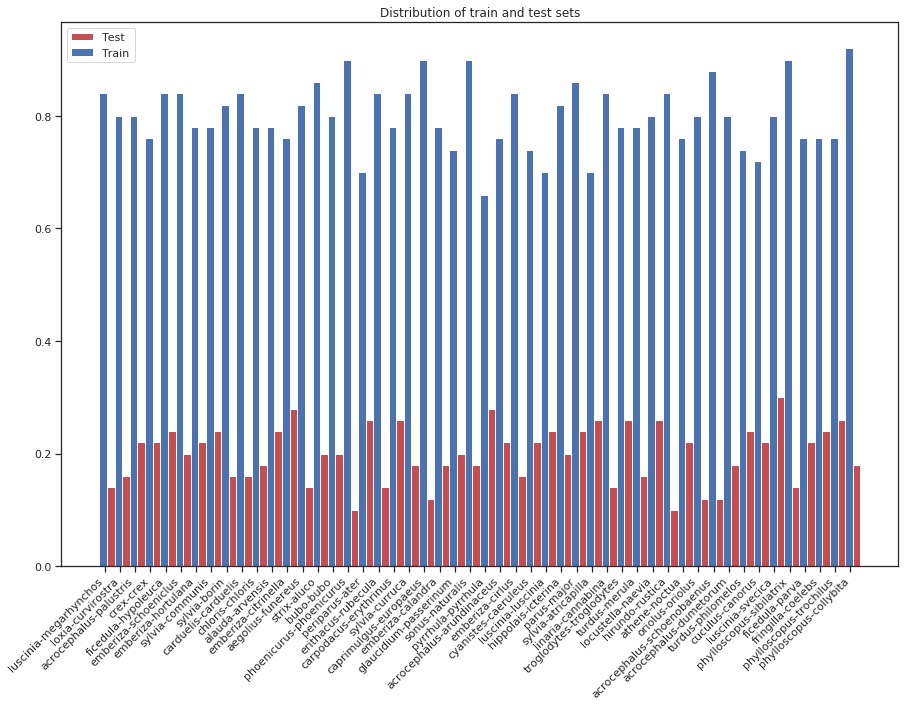

In [458]:
unique_test = np.unique(y_test, return_counts=True)
unique_train = np.unique(y_train, return_counts=True)
unique_classes = np.unique(np.concatenate((unique_test[0], unique_train[0])))

ctt = {}
for x in zip(unique_test[0], unique_test[1]):
    ctt[x[0]] = x[1]/len(unique_classes)
    
ctr = {}
for x in zip(unique_train[0], unique_train[1]):
    ctr[x[0]] = x[1]/len(unique_classes)
    
print(ctr)

width = 0.5
target_names = class_names
ind = np.arange(1, unique_classes.max() + 2)
fig, ax = plt.subplots(figsize=(15, 10))

for i in unique_classes:
    ax.bar(width * 2 + i + 1, 0 if not i in ctt else ctt.get(i), width, color='r')
    ax.bar(width + i + 1, 0 if not i in ctr else ctr.get(i), width, color='b')

ax.set_xticks(ind + width + 0.1)
ax.set_xticklabels(target_names, rotation=45, ha="right")

plt.legend(['Test', 'Train'], loc="best")
plt.title("Distribution of train and test sets");

In [551]:
from keras import optimizers

STEPS_PER_EPOCH = 1

initial_learning_rate = 0.001
decay_steps = 100
decay_rate = 0.1

lr_schedule = optimizers.schedules.InverseTimeDecay(
  initial_learning_rate,
  decay_steps=decay_steps,
  decay_rate=decay_rate
)

def get_optimizer():
    return optimizers.Adam(initial_learning_rate)

In [579]:
def get_callbacks(name):
    return [
        callbacks.EarlyStopping(monitor='loss', patience=10),
        callbacks.TensorBoard("./logs/{}".format(name)),
    ]

def compile_and_fit(model, name, max_epochs=500):
    model.compile(optimizer=get_optimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    h = model.fit(X_train,
                  y_train,
                  validation_split = 0.2,
                  callbacks=get_callbacks(name),
                  epochs=max_epochs)
    return h

In [580]:
size_histories = {}

In [581]:
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Tiny'] = compile_and_fit(model, "sizes/Tiny")

Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 4.0031 - accuracy: 0.0244 - val_loss: 4.0100 - val_accuracy: 0.0200
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 3.9164 - accuracy: 0.0294 - val_loss: 3.9508 - val_accuracy: 0.0200
Epoch 3/500
50/50 [==============================] - 0s 4ms/step - loss: 3.8558 - accuracy: 0.0512 - val_loss: 3.9105 - val_accuracy: 0.0300
Epoch 4/500
50/50 [==============================] - 0s 2ms/step - loss: 3.8030 - accuracy: 0.0675 - val_loss: 3.8768 - val_accuracy: 0.0450
Epoch 5/500
50/50 [==============================] - 0s 2ms/step - loss: 3.7532 - accuracy: 0.0781 - val_loss: 3.8435 - val_accuracy: 0.0500
Epoch 6/500
50/50 [==============================] - 0s 3ms/step - loss: 3.7019 - accuracy: 0.0950 - val_loss: 3.8129 - val_accuracy: 0.0650
Epoch 7/500
50/50 [==============================] - 0s 4ms/step - loss: 3.6499 - accuracy: 0.1063 - val_loss: 3.7862 - val_accuracy: 0.0675
Epoch 8/500


Epoch 57/500
50/50 [==============================] - 1s 11ms/step - loss: 2.6355 - accuracy: 0.3056 - val_loss: 3.3150 - val_accuracy: 0.2050
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 2.6287 - accuracy: 0.3094 - val_loss: 3.3072 - val_accuracy: 0.2025
Epoch 59/500
50/50 [==============================] - 0s 5ms/step - loss: 2.6209 - accuracy: 0.3094 - val_loss: 3.3075 - val_accuracy: 0.2075
Epoch 60/500
50/50 [==============================] - 0s 5ms/step - loss: 2.6130 - accuracy: 0.3100 - val_loss: 3.3046 - val_accuracy: 0.2050
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 2.6064 - accuracy: 0.3144 - val_loss: 3.3025 - val_accuracy: 0.2075
Epoch 62/500
50/50 [==============================] - 0s 8ms/step - loss: 2.5979 - accuracy: 0.3156 - val_loss: 3.3015 - val_accuracy: 0.2100
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 2.5906 - accuracy: 0.3169 - val_loss: 3.3011 - val_accuracy: 0.2150
Epoch

50/50 [==============================] - 0s 4ms/step - loss: 2.2198 - accuracy: 0.3931 - val_loss: 3.2847 - val_accuracy: 0.2350
Epoch 172/500
50/50 [==============================] - 0s 4ms/step - loss: 2.2188 - accuracy: 0.4025 - val_loss: 3.2831 - val_accuracy: 0.2400
Epoch 173/500
50/50 [==============================] - 0s 4ms/step - loss: 2.2183 - accuracy: 0.3975 - val_loss: 3.2855 - val_accuracy: 0.2425
Epoch 174/500
50/50 [==============================] - 0s 6ms/step - loss: 2.2144 - accuracy: 0.3981 - val_loss: 3.2825 - val_accuracy: 0.2425
Epoch 175/500
50/50 [==============================] - 0s 5ms/step - loss: 2.2131 - accuracy: 0.3956 - val_loss: 3.2912 - val_accuracy: 0.2350
Epoch 176/500
50/50 [==============================] - 0s 4ms/step - loss: 2.2112 - accuracy: 0.3963 - val_loss: 3.2848 - val_accuracy: 0.2400
Epoch 177/500
50/50 [==============================] - 0s 5ms/step - loss: 2.2095 - accuracy: 0.4038 - val_loss: 3.2901 - val_accuracy: 0.2350
Epoch 178/500

50/50 [==============================] - 0s 4ms/step - loss: 2.0763 - accuracy: 0.4244 - val_loss: 3.3904 - val_accuracy: 0.2725
Epoch 286/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0761 - accuracy: 0.4275 - val_loss: 3.3917 - val_accuracy: 0.2675
Epoch 287/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0735 - accuracy: 0.4306 - val_loss: 3.3913 - val_accuracy: 0.2725
Epoch 288/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0734 - accuracy: 0.4238 - val_loss: 3.3945 - val_accuracy: 0.2700
Epoch 289/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0746 - accuracy: 0.4250 - val_loss: 3.3994 - val_accuracy: 0.2700
Epoch 290/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0734 - accuracy: 0.4325 - val_loss: 3.3938 - val_accuracy: 0.2700
Epoch 291/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0711 - accuracy: 0.4269 - val_loss: 3.3973 - val_accuracy: 0.2700
Epoch 292/500

50/50 [==============================] - 0s 5ms/step - loss: 2.0000 - accuracy: 0.4356 - val_loss: 3.4875 - val_accuracy: 0.2800
Epoch 400/500
50/50 [==============================] - 0s 5ms/step - loss: 1.9990 - accuracy: 0.4375 - val_loss: 3.4925 - val_accuracy: 0.2800
Epoch 401/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9980 - accuracy: 0.4363 - val_loss: 3.4888 - val_accuracy: 0.2800
Epoch 402/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9985 - accuracy: 0.4344 - val_loss: 3.4901 - val_accuracy: 0.2775
Epoch 403/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9974 - accuracy: 0.4387 - val_loss: 3.4912 - val_accuracy: 0.2825
Epoch 404/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9979 - accuracy: 0.4387 - val_loss: 3.4918 - val_accuracy: 0.2775
Epoch 405/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9976 - accuracy: 0.4381 - val_loss: 3.4900 - val_accuracy: 0.2825
Epoch 406/500

In [582]:
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Small'] = compile_and_fit(model, "sizes/Small")

Epoch 1/500
50/50 [==============================] - 0s 7ms/step - loss: 3.9773 - accuracy: 0.0119 - val_loss: 3.9266 - val_accuracy: 0.0100
Epoch 2/500
50/50 [==============================] - 0s 3ms/step - loss: 3.9057 - accuracy: 0.0200 - val_loss: 3.8934 - val_accuracy: 0.0325
Epoch 3/500
50/50 [==============================] - 0s 3ms/step - loss: 3.8636 - accuracy: 0.0356 - val_loss: 3.8696 - val_accuracy: 0.0400
Epoch 4/500
50/50 [==============================] - 0s 4ms/step - loss: 3.8234 - accuracy: 0.0487 - val_loss: 3.8478 - val_accuracy: 0.0475
Epoch 5/500
50/50 [==============================] - 0s 3ms/step - loss: 3.7807 - accuracy: 0.0675 - val_loss: 3.8218 - val_accuracy: 0.0475
Epoch 6/500
50/50 [==============================] - 0s 2ms/step - loss: 3.7334 - accuracy: 0.0775 - val_loss: 3.7938 - val_accuracy: 0.0575
Epoch 7/500
50/50 [==============================] - 0s 3ms/step - loss: 3.6822 - accuracy: 0.0875 - val_loss: 3.7635 - val_accuracy: 0.0750
Epoch 8/500
5

Epoch 57/500
50/50 [==============================] - 0s 4ms/step - loss: 2.6375 - accuracy: 0.2988 - val_loss: 3.3044 - val_accuracy: 0.2050
Epoch 58/500
50/50 [==============================] - 0s 4ms/step - loss: 2.6286 - accuracy: 0.3031 - val_loss: 3.3028 - val_accuracy: 0.2075
Epoch 59/500
50/50 [==============================] - 0s 3ms/step - loss: 2.6168 - accuracy: 0.3025 - val_loss: 3.2966 - val_accuracy: 0.2075
Epoch 60/500
50/50 [==============================] - 0s 2ms/step - loss: 2.6083 - accuracy: 0.3038 - val_loss: 3.2968 - val_accuracy: 0.2075
Epoch 61/500
50/50 [==============================] - 0s 2ms/step - loss: 2.5978 - accuracy: 0.3056 - val_loss: 3.2933 - val_accuracy: 0.2175
Epoch 62/500
50/50 [==============================] - 0s 2ms/step - loss: 2.5874 - accuracy: 0.3063 - val_loss: 3.2877 - val_accuracy: 0.2200
Epoch 63/500
50/50 [==============================] - 0s 2ms/step - loss: 2.5809 - accuracy: 0.3081 - val_loss: 3.2891 - val_accuracy: 0.2250
Epoch 

50/50 [==============================] - 0s 4ms/step - loss: 2.0682 - accuracy: 0.4394 - val_loss: 3.3367 - val_accuracy: 0.2425
Epoch 172/500
50/50 [==============================] - 0s 5ms/step - loss: 2.0657 - accuracy: 0.4325 - val_loss: 3.3386 - val_accuracy: 0.2450
Epoch 173/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0629 - accuracy: 0.4350 - val_loss: 3.3489 - val_accuracy: 0.2450
Epoch 174/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0584 - accuracy: 0.4350 - val_loss: 3.3421 - val_accuracy: 0.2475
Epoch 175/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0603 - accuracy: 0.4363 - val_loss: 3.3479 - val_accuracy: 0.2400
Epoch 176/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0571 - accuracy: 0.4394 - val_loss: 3.3462 - val_accuracy: 0.2525
Epoch 177/500
50/50 [==============================] - 0s 3ms/step - loss: 2.0529 - accuracy: 0.4325 - val_loss: 3.3530 - val_accuracy: 0.2425
Epoch 178/500

50/50 [==============================] - 0s 3ms/step - loss: 1.8793 - accuracy: 0.4831 - val_loss: 3.6238 - val_accuracy: 0.2350
Epoch 286/500
50/50 [==============================] - 0s 3ms/step - loss: 1.8772 - accuracy: 0.4806 - val_loss: 3.6247 - val_accuracy: 0.2275
Epoch 287/500
50/50 [==============================] - 0s 4ms/step - loss: 1.8756 - accuracy: 0.4875 - val_loss: 3.6382 - val_accuracy: 0.2275
Epoch 288/500
50/50 [==============================] - 0s 3ms/step - loss: 1.8781 - accuracy: 0.4819 - val_loss: 3.6431 - val_accuracy: 0.2325
Epoch 289/500
50/50 [==============================] - 0s 4ms/step - loss: 1.8737 - accuracy: 0.4837 - val_loss: 3.6375 - val_accuracy: 0.2425
Epoch 290/500
50/50 [==============================] - 0s 4ms/step - loss: 1.8721 - accuracy: 0.4812 - val_loss: 3.6395 - val_accuracy: 0.2275
Epoch 291/500
50/50 [==============================] - 0s 4ms/step - loss: 1.8700 - accuracy: 0.4844 - val_loss: 3.6441 - val_accuracy: 0.2225
Epoch 292/500

50/50 [==============================] - 0s 2ms/step - loss: 1.7835 - accuracy: 0.5113 - val_loss: 3.8994 - val_accuracy: 0.2350
Epoch 400/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7820 - accuracy: 0.5075 - val_loss: 3.8989 - val_accuracy: 0.2250
Epoch 401/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7806 - accuracy: 0.5069 - val_loss: 3.8917 - val_accuracy: 0.2300
Epoch 402/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7803 - accuracy: 0.5113 - val_loss: 3.9016 - val_accuracy: 0.2400
Epoch 403/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7817 - accuracy: 0.5081 - val_loss: 3.8978 - val_accuracy: 0.2375
Epoch 404/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7808 - accuracy: 0.5069 - val_loss: 3.8915 - val_accuracy: 0.2425
Epoch 405/500
50/50 [==============================] - 0s 5ms/step - loss: 1.7775 - accuracy: 0.5088 - val_loss: 3.9045 - val_accuracy: 0.2325
Epoch 406/500

50/50 [==============================] - 0s 2ms/step - loss: 1.7448 - accuracy: 0.5163 - val_loss: 4.0516 - val_accuracy: 0.2425
Epoch 457/500
50/50 [==============================] - 0s 2ms/step - loss: 1.7470 - accuracy: 0.5138 - val_loss: 4.0477 - val_accuracy: 0.2375
Epoch 458/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7438 - accuracy: 0.5200 - val_loss: 4.0462 - val_accuracy: 0.2425
Epoch 459/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7434 - accuracy: 0.5144 - val_loss: 4.0424 - val_accuracy: 0.2475
Epoch 460/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7453 - accuracy: 0.5156 - val_loss: 4.0515 - val_accuracy: 0.2400
Epoch 461/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7446 - accuracy: 0.5150 - val_loss: 4.0514 - val_accuracy: 0.2350
Epoch 462/500
50/50 [==============================] - 0s 5ms/step - loss: 1.7420 - accuracy: 0.5188 - val_loss: 4.0602 - val_accuracy: 0.2425
Epoch 463/500

In [583]:
model = Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Medium'] = compile_and_fit(model, "sizes/Medium")

Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 3.9315 - accuracy: 0.0225 - val_loss: 3.9230 - val_accuracy: 0.0125
Epoch 2/500
50/50 [==============================] - 0s 4ms/step - loss: 3.8984 - accuracy: 0.0269 - val_loss: 3.9091 - val_accuracy: 0.0125
Epoch 3/500
50/50 [==============================] - 0s 3ms/step - loss: 3.8764 - accuracy: 0.0275 - val_loss: 3.8978 - val_accuracy: 0.0150
Epoch 4/500
50/50 [==============================] - 0s 4ms/step - loss: 3.8520 - accuracy: 0.0344 - val_loss: 3.8868 - val_accuracy: 0.0250
Epoch 5/500
50/50 [==============================] - 0s 4ms/step - loss: 3.8197 - accuracy: 0.0444 - val_loss: 3.8735 - val_accuracy: 0.0325
Epoch 6/500
50/50 [==============================] - 0s 4ms/step - loss: 3.7803 - accuracy: 0.0581 - val_loss: 3.8591 - val_accuracy: 0.0450
Epoch 7/500
50/50 [==============================] - 0s 3ms/step - loss: 3.7314 - accuracy: 0.0744 - val_loss: 3.8389 - val_accuracy: 0.0600
Epoch 8/500


Epoch 57/500
50/50 [==============================] - 0s 4ms/step - loss: 2.5908 - accuracy: 0.2975 - val_loss: 3.4698 - val_accuracy: 0.1675
Epoch 58/500
50/50 [==============================] - 0s 4ms/step - loss: 2.5813 - accuracy: 0.2925 - val_loss: 3.4697 - val_accuracy: 0.1675
Epoch 59/500
50/50 [==============================] - 0s 3ms/step - loss: 2.5745 - accuracy: 0.2912 - val_loss: 3.4676 - val_accuracy: 0.1675
Epoch 60/500
50/50 [==============================] - 0s 4ms/step - loss: 2.5661 - accuracy: 0.3025 - val_loss: 3.4668 - val_accuracy: 0.1775
Epoch 61/500
50/50 [==============================] - 0s 3ms/step - loss: 2.5597 - accuracy: 0.3081 - val_loss: 3.4519 - val_accuracy: 0.1925
Epoch 62/500
50/50 [==============================] - 0s 4ms/step - loss: 2.5489 - accuracy: 0.3150 - val_loss: 3.4546 - val_accuracy: 0.1825
Epoch 63/500
50/50 [==============================] - 0s 4ms/step - loss: 2.5399 - accuracy: 0.3119 - val_loss: 3.4499 - val_accuracy: 0.1850
Epoch 

50/50 [==============================] - 0s 4ms/step - loss: 2.0148 - accuracy: 0.4556 - val_loss: 3.5338 - val_accuracy: 0.2375
Epoch 172/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0063 - accuracy: 0.4525 - val_loss: 3.5367 - val_accuracy: 0.2375
Epoch 173/500
50/50 [==============================] - 0s 5ms/step - loss: 2.0046 - accuracy: 0.4563 - val_loss: 3.5411 - val_accuracy: 0.2400
Epoch 174/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0028 - accuracy: 0.4588 - val_loss: 3.5642 - val_accuracy: 0.2325
Epoch 175/500
50/50 [==============================] - 0s 4ms/step - loss: 2.0003 - accuracy: 0.4588 - val_loss: 3.5600 - val_accuracy: 0.2350
Epoch 176/500
50/50 [==============================] - 0s 4ms/step - loss: 1.9946 - accuracy: 0.4600 - val_loss: 3.5682 - val_accuracy: 0.2400
Epoch 177/500
50/50 [==============================] - 0s 6ms/step - loss: 1.9942 - accuracy: 0.4506 - val_loss: 3.5502 - val_accuracy: 0.2300
Epoch 178/500

50/50 [==============================] - 0s 4ms/step - loss: 1.7789 - accuracy: 0.5044 - val_loss: 3.9173 - val_accuracy: 0.2625
Epoch 286/500
50/50 [==============================] - 0s 4ms/step - loss: 1.7687 - accuracy: 0.5131 - val_loss: 3.8799 - val_accuracy: 0.2525
Epoch 287/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7673 - accuracy: 0.5088 - val_loss: 3.8883 - val_accuracy: 0.2475
Epoch 288/500
50/50 [==============================] - 0s 2ms/step - loss: 1.7704 - accuracy: 0.5169 - val_loss: 3.8868 - val_accuracy: 0.2475
Epoch 289/500
50/50 [==============================] - 0s 4ms/step - loss: 1.7696 - accuracy: 0.5106 - val_loss: 3.9145 - val_accuracy: 0.2550
Epoch 290/500
50/50 [==============================] - 0s 5ms/step - loss: 1.7618 - accuracy: 0.5081 - val_loss: 3.8958 - val_accuracy: 0.2500
Epoch 291/500
50/50 [==============================] - 0s 3ms/step - loss: 1.7690 - accuracy: 0.5088 - val_loss: 3.9138 - val_accuracy: 0.2650
Epoch 292/500

50/50 [==============================] - 0s 5ms/step - loss: 1.6435 - accuracy: 0.5431 - val_loss: 4.2274 - val_accuracy: 0.2650
Epoch 400/500
50/50 [==============================] - 0s 4ms/step - loss: 1.6431 - accuracy: 0.5475 - val_loss: 4.2625 - val_accuracy: 0.2525
Epoch 401/500
50/50 [==============================] - 0s 3ms/step - loss: 1.6414 - accuracy: 0.5487 - val_loss: 4.2226 - val_accuracy: 0.2575
Epoch 402/500
50/50 [==============================] - 0s 3ms/step - loss: 1.6391 - accuracy: 0.5494 - val_loss: 4.2240 - val_accuracy: 0.2700
Epoch 403/500
50/50 [==============================] - 0s 3ms/step - loss: 1.6435 - accuracy: 0.5381 - val_loss: 4.2531 - val_accuracy: 0.2675
Epoch 404/500
50/50 [==============================] - 0s 3ms/step - loss: 1.6370 - accuracy: 0.5431 - val_loss: 4.2570 - val_accuracy: 0.2650
Epoch 405/500
50/50 [==============================] - 0s 4ms/step - loss: 1.6384 - accuracy: 0.5512 - val_loss: 4.2264 - val_accuracy: 0.2600
Epoch 406/500

In [584]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

size_histories['Large'] = compile_and_fit(model, "sizes/Large")

Epoch 1/500
50/50 [==============================] - 1s 16ms/step - loss: 3.7627 - accuracy: 0.0894 - val_loss: 3.6207 - val_accuracy: 0.1050
Epoch 2/500
50/50 [==============================] - 0s 9ms/step - loss: 3.2065 - accuracy: 0.1744 - val_loss: 3.3222 - val_accuracy: 0.1850
Epoch 3/500
50/50 [==============================] - 0s 9ms/step - loss: 2.7771 - accuracy: 0.2650 - val_loss: 3.1121 - val_accuracy: 0.2350
Epoch 4/500
50/50 [==============================] - 0s 10ms/step - loss: 2.4087 - accuracy: 0.3600 - val_loss: 2.9058 - val_accuracy: 0.2850
Epoch 5/500
50/50 [==============================] - 0s 10ms/step - loss: 2.0787 - accuracy: 0.4319 - val_loss: 2.9959 - val_accuracy: 0.2625
Epoch 6/500
50/50 [==============================] - 0s 10ms/step - loss: 1.7354 - accuracy: 0.5138 - val_loss: 2.9442 - val_accuracy: 0.2975
Epoch 7/500
50/50 [==============================] - 1s 11ms/step - loss: 1.4632 - accuracy: 0.5675 - val_loss: 2.9326 - val_accuracy: 0.3375
Epoch 8/

Text(0.5, 0, 'Epochs [Log Scale]')

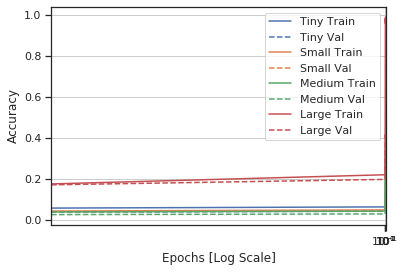

In [585]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlabel("Epochs [Log Scale]")

In [586]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorflow.keras import regularizers

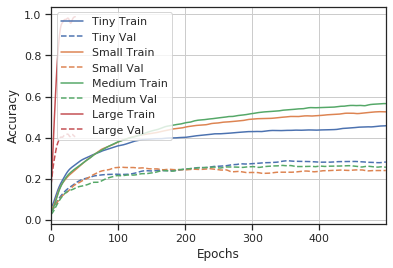

In [587]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(size_histories)

In [563]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [567]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer=regularizers.l2(0.001),))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),))
model.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['l2'] = compile_and_fit(model, "regularizers/l2")

Epoch 1/500
50/50 [==============================] - 2s 33ms/step - loss: 5.0355 - accuracy: 0.0744 - val_loss: 4.7158 - val_accuracy: 0.0950
Epoch 2/500
50/50 [==============================] - 1s 22ms/step - loss: 4.2064 - accuracy: 0.1575 - val_loss: 4.2918 - val_accuracy: 0.1575
Epoch 3/500
50/50 [==============================] - 1s 25ms/step - loss: 3.7330 - accuracy: 0.2175 - val_loss: 3.9640 - val_accuracy: 0.1800
Epoch 4/500
50/50 [==============================] - 1s 25ms/step - loss: 3.3853 - accuracy: 0.2887 - val_loss: 3.7945 - val_accuracy: 0.2675
Epoch 5/500
50/50 [==============================] - 1s 26ms/step - loss: 3.1248 - accuracy: 0.3300 - val_loss: 3.7400 - val_accuracy: 0.2600
Epoch 6/500
50/50 [==============================] - 1s 26ms/step - loss: 2.8672 - accuracy: 0.3913 - val_loss: 3.6728 - val_accuracy: 0.2600
Epoch 7/500
50/50 [==============================] - 1s 25ms/step - loss: 2.6441 - accuracy: 0.4356 - val_loss: 3.7019 - val_accuracy: 0.2550
Epoch 

In [573]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],)
                      ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['dropout'] = compile_and_fit(model, "regularizers/dropout")

Epoch 1/500
50/50 [==============================] - 1s 18ms/step - loss: 3.9745 - accuracy: 0.0194 - val_loss: 3.8858 - val_accuracy: 0.0575
Epoch 2/500
50/50 [==============================] - 1s 10ms/step - loss: 3.8896 - accuracy: 0.0431 - val_loss: 3.8380 - val_accuracy: 0.0425
Epoch 3/500
50/50 [==============================] - 1s 11ms/step - loss: 3.8184 - accuracy: 0.0606 - val_loss: 3.7686 - val_accuracy: 0.0600
Epoch 4/500
50/50 [==============================] - 1s 11ms/step - loss: 3.7050 - accuracy: 0.0831 - val_loss: 3.6799 - val_accuracy: 0.0975
Epoch 5/500
50/50 [==============================] - 0s 10ms/step - loss: 3.6103 - accuracy: 0.1006 - val_loss: 3.5842 - val_accuracy: 0.1150
Epoch 6/500
50/50 [==============================] - 1s 11ms/step - loss: 3.5033 - accuracy: 0.1106 - val_loss: 3.5440 - val_accuracy: 0.0975
Epoch 7/500
50/50 [==============================] - 1s 11ms/step - loss: 3.4295 - accuracy: 0.1381 - val_loss: 3.4205 - val_accuracy: 0.1575
Epoch 

50/50 [==============================] - 1s 12ms/step - loss: 1.0931 - accuracy: 0.6756 - val_loss: 3.0238 - val_accuracy: 0.4050
Epoch 114/500
50/50 [==============================] - 1s 11ms/step - loss: 1.0194 - accuracy: 0.6850 - val_loss: 3.0120 - val_accuracy: 0.4025
Epoch 115/500
50/50 [==============================] - 1s 11ms/step - loss: 1.0315 - accuracy: 0.6913 - val_loss: 3.0783 - val_accuracy: 0.4125
Epoch 116/500
50/50 [==============================] - 1s 10ms/step - loss: 1.1072 - accuracy: 0.6781 - val_loss: 2.9780 - val_accuracy: 0.4075
Epoch 117/500
50/50 [==============================] - 0s 10ms/step - loss: 1.0061 - accuracy: 0.6875 - val_loss: 3.0452 - val_accuracy: 0.3925
Epoch 118/500
50/50 [==============================] - 0s 10ms/step - loss: 1.0312 - accuracy: 0.6881 - val_loss: 3.0363 - val_accuracy: 0.3900
Epoch 119/500
50/50 [==============================] - 1s 11ms/step - loss: 1.1319 - accuracy: 0.6644 - val_loss: 3.0295 - val_accuracy: 0.3975
Epoch 

In [574]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', 
                       input_shape=(X_train.shape[1],),
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001),))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

regularizer_histories['combined'] = compile_and_fit(model, "regularizers/combined")

Epoch 1/500
50/50 [==============================] - 1s 17ms/step - loss: 4.1388 - accuracy: 0.0225 - val_loss: 4.0349 - val_accuracy: 0.0575
Epoch 2/500
50/50 [==============================] - 1s 10ms/step - loss: 4.0390 - accuracy: 0.0369 - val_loss: 4.0007 - val_accuracy: 0.0650
Epoch 3/500
50/50 [==============================] - 0s 9ms/step - loss: 3.9835 - accuracy: 0.0675 - val_loss: 3.9457 - val_accuracy: 0.0625
Epoch 4/500
50/50 [==============================] - 1s 11ms/step - loss: 3.8954 - accuracy: 0.0900 - val_loss: 3.8490 - val_accuracy: 0.0950
Epoch 5/500
50/50 [==============================] - 0s 9ms/step - loss: 3.7672 - accuracy: 0.1006 - val_loss: 3.7615 - val_accuracy: 0.1150
Epoch 6/500
50/50 [==============================] - 1s 11ms/step - loss: 3.6789 - accuracy: 0.1088 - val_loss: 3.6772 - val_accuracy: 0.1100
Epoch 7/500
50/50 [==============================] - 1s 11ms/step - loss: 3.5952 - accuracy: 0.1319 - val_loss: 3.6397 - val_accuracy: 0.1300
Epoch 8/

50/50 [==============================] - 1s 10ms/step - loss: 1.4787 - accuracy: 0.6712 - val_loss: 3.4117 - val_accuracy: 0.4075
Epoch 114/500
50/50 [==============================] - 1s 12ms/step - loss: 1.5419 - accuracy: 0.6825 - val_loss: 3.4048 - val_accuracy: 0.4250
Epoch 115/500
50/50 [==============================] - 1s 11ms/step - loss: 1.4886 - accuracy: 0.6844 - val_loss: 3.4543 - val_accuracy: 0.4100
Epoch 116/500
50/50 [==============================] - 1s 13ms/step - loss: 1.4193 - accuracy: 0.7075 - val_loss: 3.5014 - val_accuracy: 0.4175
Epoch 117/500
50/50 [==============================] - 1s 12ms/step - loss: 1.4625 - accuracy: 0.6938 - val_loss: 3.5569 - val_accuracy: 0.4050
Epoch 118/500
50/50 [==============================] - 1s 12ms/step - loss: 1.4929 - accuracy: 0.6844 - val_loss: 3.4869 - val_accuracy: 0.4150
Epoch 119/500
50/50 [==============================] - 1s 13ms/step - loss: 1.4798 - accuracy: 0.6806 - val_loss: 3.4214 - val_accuracy: 0.4275
Epoch 

In [576]:
from  IPython import display

In [578]:
display.IFrame(
    src="https://tensorboard.dev/experiment/EGi6eyaQRBS2wurhlCVbaA/",
    width = "100%",
    height="800px")

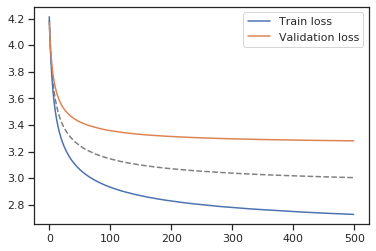

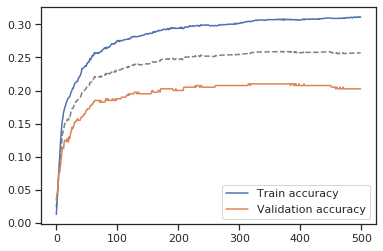

16/16 [==============================] - 0s 1ms/step - loss: 3.1797 - accuracy: 0.2140
Test score: 3.1796875
Test accuracy: 0.21400000154972076


In [523]:
for metric in h.history:
    if not metric.startswith('val'):
        for m in h.history:
            if m == "val_{}".format(metric):
                data_m = h.history[metric]
                data_val = h.history['val_{}'.format(metric)]
                
                plt.plot(np.mean([data_m, data_val], axis=0), color="grey", linestyle='dashed')
                plt.plot(data_m, label="Train {}".format(metric))
                plt.plot(data_val, label="Validation {}".format(metric))

                plt.legend()
                plt.show()

out = model.evaluate(X_test, y_test)
print('Test score:', out[0])
print('Test accuracy:', out[1])

In [393]:
class_names

array(['luscinia-megarhynchos', 'loxia-curvirostra',
       'acrocephalus-palustris', 'crex-crex', 'ficedula-hypoleuca',
       'emberiza-schoeniclus', 'emberiza-hortulana', 'sylvia-communis',
       'sylvia-borin', 'carduelis-carduelis', 'chloris-chloris',
       'alauda-arvensis', 'emberiza-citrinella', 'aegolius-funereus',
       'strix-aluco', 'bubo-bubo', 'phoenicurus-phoenicurus',
       'periparus-ater', 'erithacus-rubecula', 'carpodacus-erythrinus',
       'sylvia-curruca', 'caprimulgus-europaeus', 'emberiza-calandra',
       'glaucidium-passerinum', 'sonus-naturalis', 'pyrrhula-pyrrhula',
       'acrocephalus-arundinaceus', 'emberiza-cirlus',
       'cyanistes-caeruleus', 'luscinia-luscinia', 'hippolais-icterina',
       'parus-major', 'sylvia-atricapilla', 'linaria-cannabina',
       'troglodytes-troglodytes', 'turdus-merula', 'locustella-naevia',
       'hirundo-rustica', 'athene-noctua', 'oriolus-oriolus',
       'acrocephalus-schoenobaenus', 'acrocephalus-dumetorum',
     

In [394]:
prediction = model.predict(X_test[0].reshape((1, len(X_test[0]))))
encoder.inverse_transform([prediction[0].argmax()])

array(['acrocephalus-palustris'], dtype=object)

In [395]:
X_test[0]

array([-3.24003897e-03, -9.93386300e-01,  9.90856618e-01, -8.70769843e-01,
       -7.92843362e-01, -2.66590959e-01, -5.37133238e-02, -8.64294949e-01,
        1.59657149e+00,  1.74047576e+00, -9.43498595e-01,  3.08708705e+00,
        4.26610997e-01,  2.28329899e+00, -4.48873482e-01,  1.48583524e+00,
        1.72156994e+00,  2.18324043e+00, -1.03231098e+00,  3.25783416e+00,
       -8.52961993e-01, -2.15086803e-01, -9.05983152e-01,  1.37991234e+00,
       -5.98329536e-01,  0.00000000e+00, -1.12029947e-01,  1.41464677e-01,
       -7.65115437e-01])

In [396]:
out = model.evaluate(X_test, y_test)
print('Test score:', out[0])
print('Test accuracy:', out[1])

16/16 [==============================] - 0s 2ms/step - loss: 6.8822 - accuracy: 0.4060
Test score: 6.882208347320557
Test accuracy: 0.4059999883174896


In [397]:
y_pred = model.predict(X_test).argmax(axis=1)
print(len(y_pred))
print(len(y_test))

500
500


['luscinia-megarhynchos' 'loxia-curvirostra' 'acrocephalus-palustris'
 'crex-crex' 'ficedula-hypoleuca' 'emberiza-schoeniclus'
 'emberiza-hortulana' 'sylvia-communis' 'sylvia-borin'
 'carduelis-carduelis' 'chloris-chloris' 'alauda-arvensis'
 'emberiza-citrinella' 'aegolius-funereus' 'strix-aluco' 'bubo-bubo'
 'phoenicurus-phoenicurus' 'periparus-ater' 'erithacus-rubecula'
 'carpodacus-erythrinus' 'sylvia-curruca' 'caprimulgus-europaeus'
 'emberiza-calandra' 'glaucidium-passerinum' 'sonus-naturalis'
 'pyrrhula-pyrrhula' 'acrocephalus-arundinaceus' 'emberiza-cirlus'
 'cyanistes-caeruleus' 'luscinia-luscinia' 'hippolais-icterina'
 'parus-major' 'sylvia-atricapilla' 'linaria-cannabina'
 'troglodytes-troglodytes' 'turdus-merula' 'locustella-naevia'
 'hirundo-rustica' 'athene-noctua' 'oriolus-oriolus'
 'acrocephalus-schoenobaenus' 'acrocephalus-dumetorum' 'turdus-philomelos'
 'cuculus-canorus' 'luscinia-svecica' 'phylloscopus-sibilatrix'
 'ficedula-parva' 'fringilla-coelebs' 'phylloscopus-tr

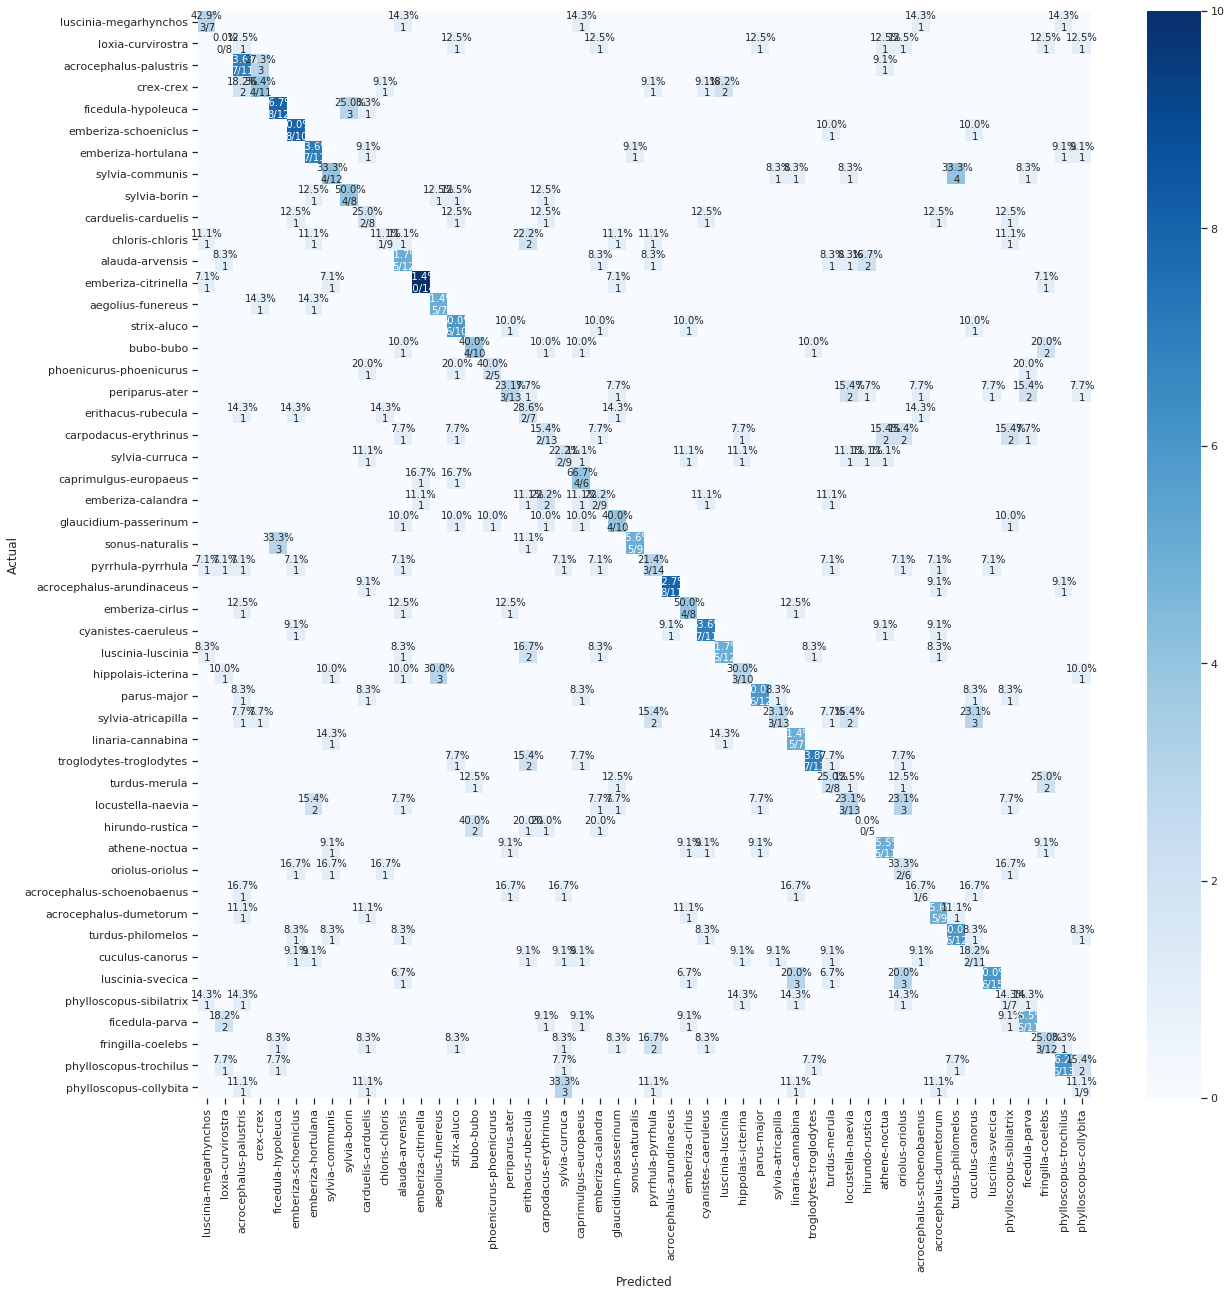

In [398]:
plot_confusion_matrix(y_test, y_pred, [x for x in range(len(birds_classes.unique()))], ymap=birds_classes.unique(), figsize=(20,20))